# PW1 - Handwritten character recognition


In [1]:
# Write your name here (e.g. "Edmond Dantès") so I can grade your work
your_name = "Paul-Constant TOUDRET"
assert your_name

In [87]:
%matplotlib inline
import math, sys, os, time

import numpy as np
import torch
import torch.optim
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


We will be training many models. Select a number of epochs to train each model. If you are using a slow machine, or if you want to restart training often and have many development iterations, we suggest `NUM_EPOCH = 2`. If you are using a fast machine, or have a GPU available, of if you are confident that you can write accurate code first try, you will get better accuracies by increasing this constant. You could be able to afford up to `NUM_EPOCH = 10`.

# Part A - Linear, MLP, and CNN


## Handwritten digit recognition dataset

We will use the MNIST database (Modified National Institute of Standards and Technology database). It contains tens of thousands of pictures of handwritten digits. This database was compiled in 1994, as part of the effort in the 1990s to standardize automation of sorting devices with human input, for instance sorting mail with handwritten postal codes at the post office. This is now often considered one of the first real successes of neural networks, and the first easy example on which performance of new such algorithms is tested.

Load the dataset (train and test splits) using `torchvision`

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor

root_dir = './data/MNIST/'

"""
Code taken from Torch Doc
"""

training_data = datasets.MNIST(
    root=root_dir,
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root=root_dir,
    train=False,
    download=True,
    transform=ToTensor()
)


How many examples in each split? 

Plot the first image and label of the training set using `matplotlib`

What is the input dimension?

number of training example : 60000
number of test example : 10000


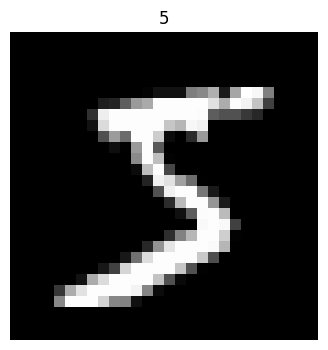

In [79]:
### Number of examples

print(f"number of training example : {len(training_data)}")
print(f"number of test example : {len(test_data)}")

### First image and label of training
"""
Code taken from Torch Doc
"""

figure = plt.figure(figsize=(4, 4))
#sample_idx = torch.randint(len(training_data), size=(1,)).item()
img, label = training_data[0]
plt.title(label)
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [80]:
### Dimension of the input

d, w, h = training_data[0][0].shape
print(f"dimension of image : {d}")      # Only Grey Scale
print(f"height of image : {h} pixels")
print(f"width of image : {w} pixels")


dimension of image : 1
height of image : 28 pixels
width of image : 28 pixels


## A.1 - Linear features

We start with a very simple model, linear with respect to pixel values.
Use a `preprocess` function to downsample the image to 7x7 pixels, then flatten it and use a `torch.nn.Linear` model.

The torch average-pooling function is `torch.nn.functional.avg_pool2d`, check the documentation to set the arguments properly.
DO NOT use your implementation of average-pooling, it would take prohibitively long to train and you would not finish the practical.
If the training takes too long, go back to the first section and lower the `NUM_EPOCH` constant.

Again, use matplotlib to visualize an example of downsampling

In [84]:

preprocess = nn.Sequential(
    nn.AvgPool2d(
    kernel_size=4,
    stride=4
    ),
    nn.Flatten()
)
"""
Stride = 4 -> we divide the dimensions by 4 to get 7 X 7 pixels
Kernel size = 4 
"""
f_img = preprocess(training_data[0][0])

d, w, h = img.shape
print(f"dimension of image : {d}")      # Only Grey Scale
print(f"height of image : {h} pixels")
print(f"width of image : {w} pixels")

d, w = f_img.shape
print(f"dimension of flatten image : {d}")      # Only Grey Scale
print(f"width of flatten image : {w} pixels")

dimension of image : 1
height of image : 28 pixels
width of image : 28 pixels
dimension of flatten image : 1
width of flatten image : 49 pixels


In [ ]:
### Simple Linear Model with no hidden layer

class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
            super().__init__()
            
            self.input_size = input_size
            self.output_size = output_size
            
            # Second Step -> Apply only Linear layer
            self.model = nn.Linear(self.input_size, self.output_size)
            
    def forward(self, x):
        x = x.reshape(-1, self.input_size)
        x = self.model(x)
        return x

## A.2 - Loss and optimizer
Create a cross entropy loss.

In [ ]:
### Nous définissons le modèle avant de définir la fonction de perte et l'optimiseur
### Cela est important uniquement pour l'optimiseur qui prend les paramètres du modèle en entrée

nn1 = LinearModel(
    input_size=49,
    output_size=10
)

c_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nn1.parameters(), lr=0.001, momentum=0.8)

## A.3 - Training and testing loops
Finally, create the functions `train(model, epoch, preprocess, optimizer)` and `test(model)` to train (one epoch with SGD and a learning rate of $10^{-3}$) and test your model.

In [90]:
### On prend le parti de faire le preprocessing des données hors de la boucle d'entrainement
### Cela a pour but de ne pas ralentir l'entrainement

def prep_data(preprocess, training_data, test_data):
    """
    preprocess : preprocessing function
    training_data : training data raw from MNIST
    test_data : test data raw from MNIST
    """
    print(f'shape of  data : {training_data[0][0].shape}')
    
    preprocess_train = []
    preprocess_test = []

    print(f'Preprocessing Training Set')
    for img, label in training_data:
        preprocess_train.append((preprocess(img), label))

        if len(preprocess_train) % 100 == 0 and len(preprocess_train) < len(training_data):
            print(f"Preprocess en cours : {len(preprocess_train)} of {len(training_data)}", end='\r')
        elif len(preprocess_train) == len(training_data):
            print(f"Preprocess en cours : {len(preprocess_train)} of {len(training_data)}", end='\n')


    print(f'Preprocessing Test Set')
    for img, label in test_data:
        preprocess_test.append((preprocess(img), label))

        if len(preprocess_test) % 100 == 0 and len(preprocess_test) < len(test_data):
            print(f"preprocess en cours : {len(preprocess_test)} of {len(test_data)}", end='\r')
        elif len(preprocess_test) == len(test_data):
            print(f"preprocess en cours : {len(preprocess_test)} of {len(test_data)}", end='\n')

    print(f'shape of processed data : {preprocess_train[0][0].shape}')
    return preprocess_train, preprocess_test

In [91]:
# On preprocess le test_data juste pour optimiser le temps de calculs
# On transforme ici nos tenseurs (1, 28, 28) en (1, 49)

prep_train, prep_test = prep_data(
    preprocess=preprocess,
    training_data=training_data,
    test_data=test_data
    )

shape of  data : torch.Size([1, 28, 28])
Preprocessing Training Set
Preprocess en cours : 60000 of 60000
Preprocessing Test Set
preprocess en cours : 10000 of 10000
shape of processed data : torch.Size([1, 49])


In [127]:
### Définition de la fonction d'entrainement, de test et de validation

def train(
    model,                  # Modèle à entrainer
    training_data,          # Données d'entrainement déjà prétraitées. (doivent convenir au modèle)
    optimizer,              # Optimiseur    
    criterion,              # Fonction de perte
    epoch: int = 5,         # Nombre d'époques
    batch_size: int =32,    # Taille du batch
    ):
    """ 
    Prend en entrée :
    - le modèle
    - les données d'entrainement
    - l'optimiseur
    - la fonction de perte
    - le nombre d'époques
    - la taille du batch

    Renvoie :
    - l'optimiseur
    - la perte moyenne

    Nota : On gère le flatten des tenseurs ou la réduction de dimension dans le modèle directement
    """

    # On met le modèle en mode entrainement
    model.train()

    # On gère les données d'entrainement avec un DataLoader
    # On shuffle les données d'entrainement pokkkur éviter de faire du sur-apprentissage
    dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

    # Nombre de batch pour une époque
    n_iter = round(len(training_data) / batch_size,0) + 1

    # On va iterer sur le nombre d'époques
    for ep in range(epoch):
        s=time.time()
        print(f"Entering epoch n°{ep+1}")

        total_loss = 0.0            # Initialisation de la perte totale
        batch = 0                   # Initialisation du batch (seulement pour l'affichage)

        for inputs, targets in dataloader:
            if batch == 0 and ep == 0:
                print(f'inputs shape : {inputs.shape}')

            # Forward et loss
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            if batch == 0 and ep == 0:
                print(f'outputs shape : {outputs.shape}')

            print(f'batch {round(100*(batch+1)/n_iter,0)} %', end='\r')

            # On réinitialise le gradient de l'optimiseur à 0
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            batch += 1
            
        avg_loss = total_loss / len(training_data)
        e = time.time()

        print(f"Epoch {ep+1}/{epoch} - Loss: {avg_loss:.4f} - {round(e-s,1)}s.")

    return optimizer, avg_loss


def test(
        model,
        test_data,
        cmap:str = "Blues",
        show_matrix: bool = False,
        show_distribution: bool = False,
    ):
    """ 
    Prend en entrée :
    - le modèle
    - les données de test
    - cmap : couleur de la matrice de confusion
    - show_matrix : True/False pour afficher la matrice de confusion
    Renvoie :
    - la précision du modèle sur les données de test
    - Affiche la matrice de confusion
    """

    model.eval()  # mode évaluation
    
    correct = 0
    total = len(test_data)

    dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

    # utilisé pour la matrice de confusion
    y_targets = []
    y_pred = []

    with torch.no_grad():  # pas de backpropagation
        for inputs, target in dataloader:

            output = model(inputs)
            predicted = output.argmax(dim=1).item()  # classe prédite

            y_targets.append(target)
            y_pred.append(predicted)

            if predicted == target:
                correct += 1

    accuracy = correct / total

    matrix = confusion_matrix(y_true=y_targets, y_pred=y_pred)

    if show_distribution:
        figure = plt.figure(figsize=(4, 4))
        list_errors = []
        for i in range(len(matrix)):
            for j in range(len(matrix)):
                if i != j:
                    list_errors.append((matrix[i][j]))
        plt.hist(list_errors, bins=max(list_errors) + 1, color='gray', alpha=0.7)
        plt.title('Distribution of errors')
        plt.xlabel('Number of errors')
        plt.ylabel('Frequency')
        plt.show()

    if show_matrix:
        disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
        disp.figure(figsize= (4, 4))
        disp.plot(cmap='Blues', xticks_rotation='vertical')
        plt.show()
    
    
    return accuracy

You should get at least 85\% test accuracy even with only 2 epochs. We will be aiming for around 95\% test accuracy and above.

In [95]:
# On redéfinit le modèle, le critère et l'optimiseur


NUM_EPOCH = 5

nn1 = LinearModel(
    input_size = 49,
    output_size = 10
)
optimizer = torch.optim.SGD(nn1.parameters(), lr=0.01, momentum=0.9)

opti, loss = train(
    model=nn1,
    epoch=NUM_EPOCH,
    criterion=nn.CrossEntropyLoss(),
    training_data=prep_train,
    optimizer=optimizer,
    batch_size=50
    )
loss

Entering epoch n°1
inputs shape : torch.Size([50, 1, 49])
outputs shape : torch.Size([50, 10])
Epoch 1/5 - Loss: 0.0258 - 0.3s.
Entering epoch n°2
Epoch 2/5 - Loss: 0.0154 - 0.2s.
Entering epoch n°3
Epoch 3/5 - Loss: 0.0130 - 0.2s.
Entering epoch n°4
Epoch 4/5 - Loss: 0.0119 - 0.2s.
Entering epoch n°5
Epoch 5/5 - Loss: 0.0112 - 0.2s.


0.01120785119732221

torch.Size([1, 1, 49])
torch.Size([1, 10])


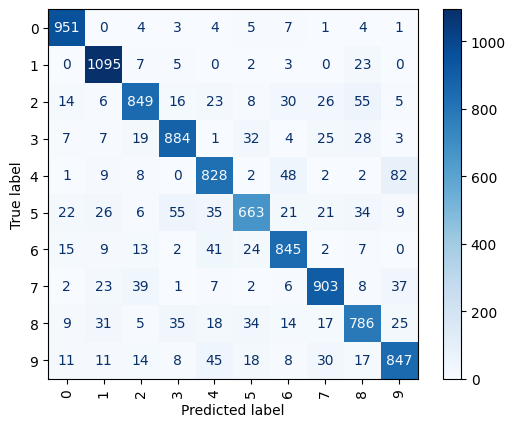

0.8651


In [93]:
accuracy = test(
    model = nn1,
    test_data=prep_test,
    show_matrix = True
)
print(accuracy)

## A.4 - Multi-layer perceptron (MLP)

Create a class MLP that creates an MLP of given width and depth, and use it to create a 3-layer MLP of width $100$. We will assume that `width > 0` and `depth > 0`.

In [ ]:
# Défintion de la classe MLP
class MLP(nn.Module):
    def __init__(self, input_size, output_size, width, depth):
        super().__init__()

        layers = []

        # Première couche : input -> hidden
        layers.append(nn.Linear(input_size, width))
        layers.append(nn.ReLU())

        # Couches intermédiaires : hidden -> hidden (depth - 1 fois)
        for _ in range(depth - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())

        # Dernière couche : hidden -> output
        layers.append(nn.Linear(width, output_size))

        # Assemblage du réseau
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # s'assurer que l'entrée est de forme (batch, input_size)
        return self.model(x)


In [96]:
mlp1 = MLP(
    input_size= 49,
    output_size= 10,
    width= 100,
    depth=3
)
NUM_EPOCH = 5

optimizer = torch.optim.SGD(mlp1.parameters(), lr=0.01, momentum=0.9)

opti, loss = train(
    model=mlp1,
    epoch=NUM_EPOCH,
    criterion=nn.CrossEntropyLoss(),
    training_data=prep_train,
    optimizer=optimizer,
    batch_size=50,
    )
loss

Entering epoch n°1
inputs shape : torch.Size([50, 1, 49])
outputs shape : torch.Size([50, 10])
Epoch 1/5 - Loss: 0.0238 - 0.4s.
Entering epoch n°2
Epoch 2/5 - Loss: 0.0073 - 0.4s.
Entering epoch n°3
Epoch 3/5 - Loss: 0.0051 - 0.4s.
Entering epoch n°4
Epoch 4/5 - Loss: 0.0041 - 0.4s.
Entering epoch n°5
Epoch 5/5 - Loss: 0.0036 - 0.4s.


0.003644499886718889

torch.Size([1, 1, 49])
torch.Size([1, 10])


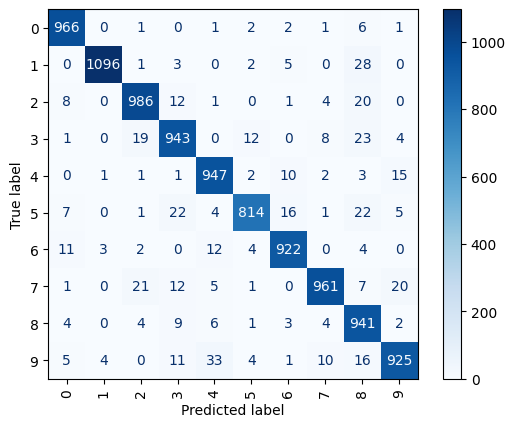

0.9501


In [97]:
accuracy = test(
    model = mlp1,
    test_data=prep_test,
    show_matrix=True
)
print(accuracy)

On constate une meilleur taux de réussite du modèle. 
Notamment le modèle se trompe très peu sur certains couples par exemple (1, 4). 
Il est intéressant de noter que le modèle fait par exemple beaucoup plus d'erreurs de prédiction de 2 pour une target de 7 que l'inverse.


# A.5 - Deep convolutional model

Write a convolutional model, with learned features.
Use two layers, one convolutional with 8 filters of size 3x3, then take a relu and max-pool with kernel size 2, and finally flatten and add a Linear layer. You can use the identity as pre-processing function.


Here is a little animation to remind you of the sliding window principle of convolutions.

![conv](https://github.com//vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif)

In [98]:
# On preprocess le training_data juste pour optimiser le temps de calculs
# Ici on garde les tensor de dim 28 X 28
# Cette étape ne sert donc à rien mais on la garde pour la suite, juste pour garder la même structure

preprocess = nn.AvgPool2d(kernel_size=1,stride=1)

conv_train, conv_test = prep_data(
    preprocess=preprocess,
    training_data=training_data,
    test_data=test_data
)


shape of  data : torch.Size([1, 28, 28])
Preprocessing Training Set
Preprocess en cours : 60000 of 60000
Preprocessing Test Set
preprocess en cours : 10000 of 10000
shape of processed data : torch.Size([1, 28, 28])


In [100]:
class ConvModel(torch.nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),  # (batch, 1, 28, 28) -> (batch, 8, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # 8 channels, 14 x 14 feature map (car MaxPool2d divise par 2 avec son kernel de 2
        self.dim = 8 * 14 * 14

        self.classifier = nn.Linear(self.dim, 10)  # Flatten + Linear

    def forward(self, x):
        x = self.conv(x)               # (batch, 1, 28, 28) -> (batch, 8, 13, 13)
        x = x.view(x.size(0), -1)      # Flatten
        x = self.classifier(x)         # (batch, 1352) -> (batch, 10)
        return x

Entering epoch n°1
inputs shape : torch.Size([50, 1, 28, 28])
outputs shape : torch.Size([50, 10])
Epoch 1/5 - Loss: 0.0067 - 2.6s.
Entering epoch n°2
Epoch 2/5 - Loss: 0.0027 - 2.8s.
Entering epoch n°3
Epoch 3/5 - Loss: 0.0019 - 2.8s.
Entering epoch n°4
Epoch 4/5 - Loss: 0.0016 - 2.7s.
Entering epoch n°5
Epoch 5/5 - Loss: 0.0014 - 2.7s.
0.0014121175371808931
torch.Size([1, 1, 28, 28])
torch.Size([1, 10])


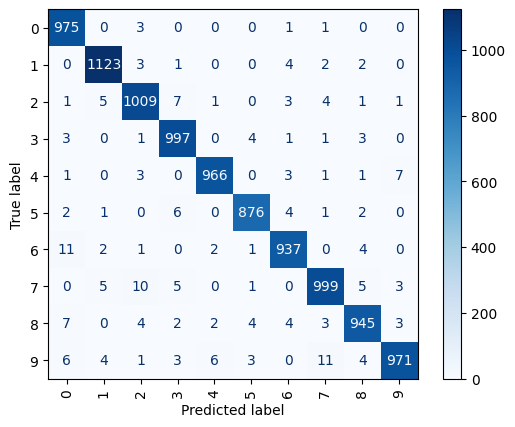

0.9798


In [ ]:
conv = ConvModel()

NUM_EPOCH = 5

opti, loss = train(
    model=conv,
    epoch=NUM_EPOCH,
    criterion=nn.CrossEntropyLoss(),
    training_data=conv_train,
    optimizer=torch.optim.SGD(conv.parameters(), lr=0.01, momentum=0.9),
    batch_size=50
    )
print(loss)



In [ ]:
accuracy = test(
    model = conv,
    test_data=conv_test,
    show_matrix=True,
    show_distribution=True
)
print(accuracy)

On constate une amélioration jusqu'à 98% de précision. Par ailleurs toutes les erreurs de catégorisation sont inférieures à 10 (alors que certaines dépassées 20 précédemment). On a donc gagné en robustesse pour notre modèle.

In [ ]:
conv = ConvModel()

NUM_EPOCH = 20

opti, loss = train(
    model=conv,
    epoch=NUM_EPOCH,
    criterion=nn.CrossEntropyLoss(),
    training_data=conv_train,
    optimizer=torch.optim.SGD(conv.parameters(), lr=0.01, momentum=0.9),
    batch_size=50
    )
print(loss)


Entering epoch n°1
inputs shape : torch.Size([50, 1, 28, 28])
outputs shape : torch.Size([50, 10])
Epoch 1/20 - Loss: 0.0070 - 2.7s.
Entering epoch n°2
Epoch 2/20 - Loss: 0.0029 - 2.7s.
Entering epoch n°3
Epoch 3/20 - Loss: 0.0020 - 2.6s.
Entering epoch n°4
Epoch 4/20 - Loss: 0.0016 - 2.6s.
Entering epoch n°5
Epoch 5/20 - Loss: 0.0014 - 2.6s.
Entering epoch n°6
Epoch 6/20 - Loss: 0.0013 - 2.6s.
Entering epoch n°7
Epoch 7/20 - Loss: 0.0012 - 2.6s.
Entering epoch n°8
Epoch 8/20 - Loss: 0.0011 - 2.7s.
Entering epoch n°9
Epoch 9/20 - Loss: 0.0010 - 2.7s.
Entering epoch n°10
Epoch 10/20 - Loss: 0.0010 - 2.7s.
Entering epoch n°11
Epoch 11/20 - Loss: 0.0009 - 2.6s.
Entering epoch n°12
Epoch 12/20 - Loss: 0.0009 - 2.7s.
Entering epoch n°13


In [ ]:

accuracy = test(
    model = conv,
    test_data=conv_test,
    show_matrix=True,
    show_distribution=True
)
print(accuracy)


On ne constate pas d'augmentation de la précision si importante que ça. Le modèle fait même des erreurs parfois plus grande que précédemment : par exemple 14 occurences qui prédisent 5 au lieu de 9.

On sent que le modèle est peut-être en train d'overfitter.

You should be able to get around 97\% to 98\% accuracy with this model. Try increasing the NUM_EPOCH constant and watch what happens to test accuracy and train accuracy as training progresses further.

Write a deeper convolutional model, with one convolutional layer as previously, but three linear layers with relu activations after that.
Use `h = 100` hidden neurons. How does the test accuracy compare with the previous two-layer network ?

In [106]:
class ConvDeepModel(torch.nn.Module):
    def __init__(self):
        super(ConvDeepModel, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),  # (batch, 1, 28, 28) -> (batch, 8, 28, 28)
            nn.ReLU(),
        )

        self.dim = 8 * 14 * 14


        self.classifier = nn.Sequential(
            nn.Linear(self.dim, 100),
            nn.Relu(),
            nn.Linear(100,100),
            nn.Relu(),
            nn.Linear(100,10)
        )

    def forward(self, x):
        x = self.conv(x)               # (batch, 1, 28, 28) -> (batch, 8, 13, 13)
        x = x.view(x.size(0), -1)      # Flatten
        x = self.classifier(x)         # (batch, 1352) -> ... -> (batch, 10)
        return x


Entering epoch n°1
inputs shape : torch.Size([50, 1, 28, 28])
outputs shape : torch.Size([50, 10])
Epoch 1/5 - Loss: 0.0071 - 2.6s.
Entering epoch n°2
Epoch 2/5 - Loss: 0.0032 - 2.6s.
Entering epoch n°3
Epoch 3/5 - Loss: 0.0023 - 2.5s.
Entering epoch n°4
Epoch 4/5 - Loss: 0.0019 - 2.5s.
Entering epoch n°5
Epoch 5/5 - Loss: 0.0017 - 2.5s.
0.0016795098914997653
torch.Size([1, 1, 28, 28])
torch.Size([1, 10])


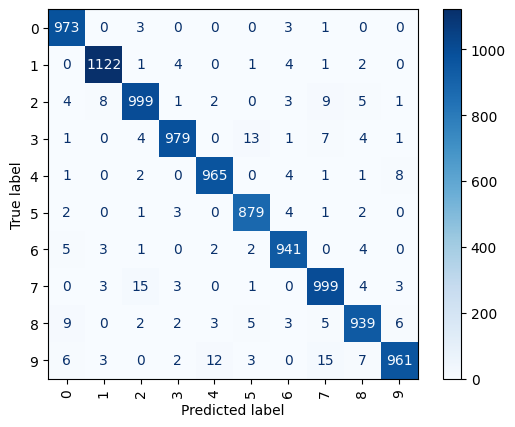

0.9757


In [108]:
deep_conv = ConvModel()

NUM_EPOCH = 5

opti, loss = train(
    model=deep_conv,
    epoch=NUM_EPOCH,
    criterion=nn.CrossEntropyLoss(),
    training_data=conv_train,
    optimizer=torch.optim.SGD(deep_conv.parameters(), lr=0.01, momentum=0.9),
    batch_size=50,
    )
print(loss)

accuracy = test(
    model = deep_conv,
    test_data=conv_test,
    show_matrix=True
)
print(accuracy)

La précision de ce modèle n'est pas meilleure que le modèle avec uniquement 2 couches. On observe même des erreurs de prédictions supérieures à 10 occurences pour certaines associations comme 15 occurences de 2 au lieu de 7.
 
 Les couches d'activation ne donnent pas l'impression d'améliorer les performances du modèles.

## A.6 Visualisations of convolutions

After training your model, let's see what features it has learned!

Plot an image from the test set then plot all 8 feature maps extracted by the convolutional layer

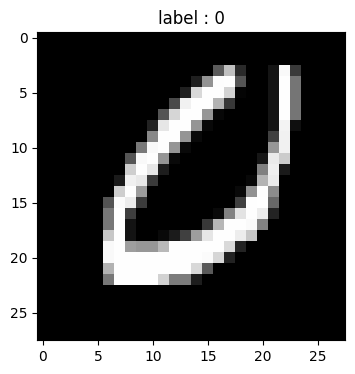

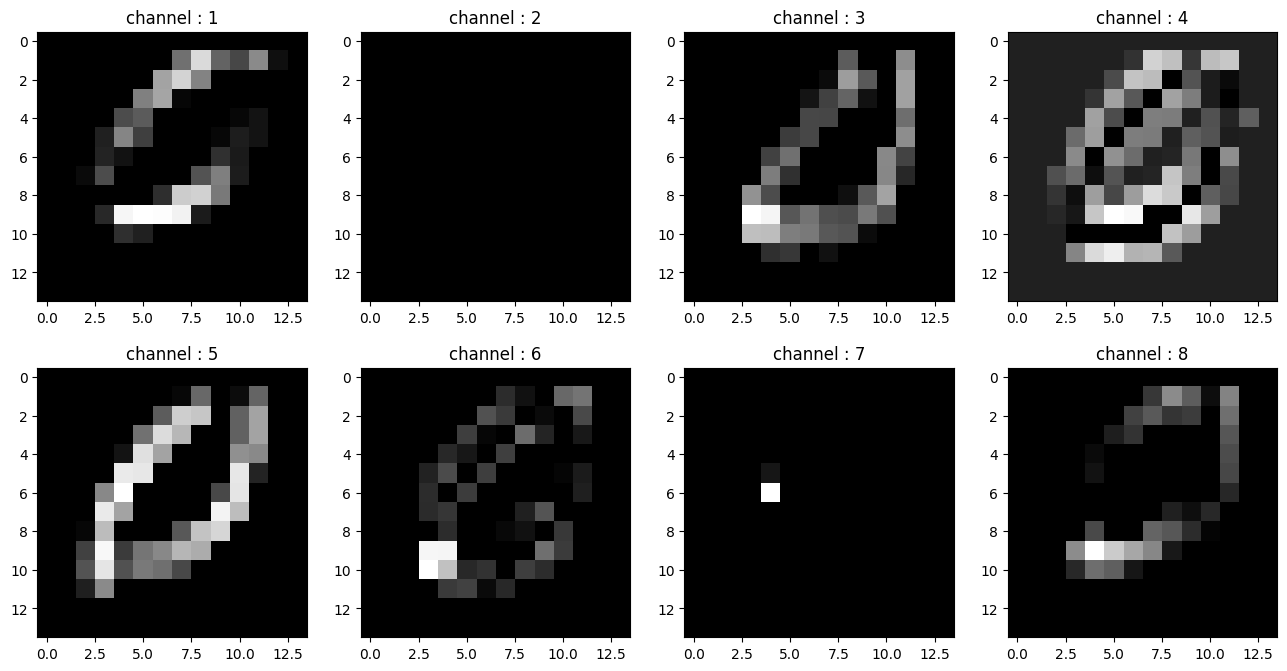

In [110]:
n = np.random.randint(low=0, high=len(conv_test) -1)

img, label = conv_test[n]

# On applique uniquement le conv sur l'image
channels = deep_conv.conv(img).detach().numpy()

# On redimensionne l'image pour l'afficher
img_plot = img.view(28,-1)

plt.figure(figsize=(4,4))
plt.imshow(img_plot, cmap='gray')
plt.title(f'label : {label}')



figure = plt.figure(figsize=(16, 8))

# On affiche les 8 channels
cols, rows = 4, 2

for i in range(0, cols * rows):
    img = channels[i]
    figure.add_subplot(rows, cols, i + 1)
    plt.title(f"channel : {i + 1}")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Part B - Residual models

## B.1 - Residual blocks

Write a residual block with two linear layers to learn a function $\mathbb{R}^d \to \mathbb{R}^d$ with $h < d$ hidden neurons.
Write a convolutional residual block with the same idea. What hyperparameter acts as the number of hidden neurons in convolutional blocks ?

In [ ]:
# Bloc résiduel avec un étrangement de dimension en passant de d -> h -> d
# Par ailleurs on renvoie le tenseur d'entrée après le forward pour que lors de la backpropagation
# on puisse faire le gradient de la fonction d'erreur par rapport à l'entrée

class ResidualBlock(torch.nn.Module):
    def __init__(self, d, h):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Linear(d, h),
            nn.ReLU(),
            nn.Linear(h, d)
        )

    def forward(self, x):
        out = self.block(x)
        return x + out

In [112]:
# Bloc résiduel avec un étrangement de dimension en passant mais cette fois-ci
# c'est le nombre de channels qui sert de goulot d'étranglement :
# in_channels -> hidden_channels -> in_channels
# Les dimensions de ces channels restent inchangées kernel = 3 & padding = 1.

class ConvResidualBlock(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(ConvResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, in_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        out = self.block(x)
        return x + out

## B.2 - Stacking residual blocks

Use a single convolution layer, followed by a relu and max-pool, then an arbitrary number of residual blocks as defined above, and finish with a linear layer. Can you match the accuracy of the two-layer network ? Can you exceed it ? What happens when you increase the number of layers ? Look at the details of the ResNet architecture on the lecture's slides to get an idea of how to increase the number of hidden neurons and the number of layers. One of the strengths of ResNets was there relatively low number of parameters compared
to a multi-layer architecture like that of the previous section, does this show in your experiments ?

In [113]:

class ResidualModel(nn.Module):
    def __init__(
            self,
            l,      # Nombre de blocs résiduels
            h,      # Nombre de channels cachés
            k=3,    # Taille du kernel
            out=8   # Nombre de channels de sortie
        ):
        super(ResidualModel, self).__init__()
        
        # 1. Convolution initiale + activation + pool
        self.initial = nn.Sequential(
            nn.Conv2d(1, out, kernel_size=k, padding=k//2, stride=1),  # input MNIST: (1, 28, 28), on veut garder les mêmes dimensions
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)                      # -> (out, 14, 14)
        )
        
        # 2. Empilement de l blocs résiduels
        self.residuals = nn.Sequential(
            *[ConvResidualBlock(out, h) for _ in range(l)]
        )

        # 3. Classificateur
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(out * 14 * 14, 10)
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.residuals(x)
        x = self.classifier(x)
        return x

Entering epoch n°1
inputs shape : torch.Size([50, 1, 28, 28])
outputs shape : torch.Size([50, 10])
Epoch 1/5 - Loss: 0.0038 - 17.8s.
Entering epoch n°2
Epoch 2/5 - Loss: 0.0013 - 17.7s.
Entering epoch n°3
Epoch 3/5 - Loss: 0.0010 - 17.3s.
Entering epoch n°4
Epoch 4/5 - Loss: 0.0009 - 17.6s.
Entering epoch n°5
Epoch 5/5 - Loss: 0.0008 - 17.8s.
0.0007845653087453683
torch.Size([1, 1, 28, 28])
torch.Size([1, 10])


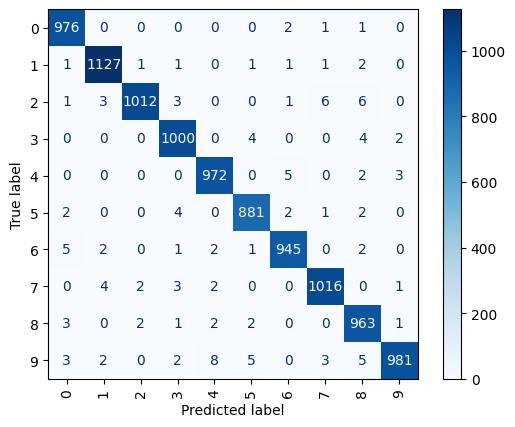

0.9873


In [ ]:
# ResNet témoin (l = 3, h = 4)

ResNet = ResidualModel(
    l=3, # number of residual blocks
    h=4, # bottleneck h < out
    k=3, # kernel of first conv
    out=8 # number of output channels after first conv2D 
)

NUM_EPOCH = 5

opti, loss = train(
    model=ResNet,
    epoch=NUM_EPOCH,
    criterion=nn.CrossEntropyLoss(),
    training_data=conv_train,
    optimizer=torch.optim.SGD(ResNet.parameters(), lr=0.01, momentum=0.9),
    batch_size=50
    )
print(loss)

accuracy = test(
    model = ResNet,
    test_data=conv_test,
    show_matrix=True,
    show_distribution=True
)
print(accuracy)


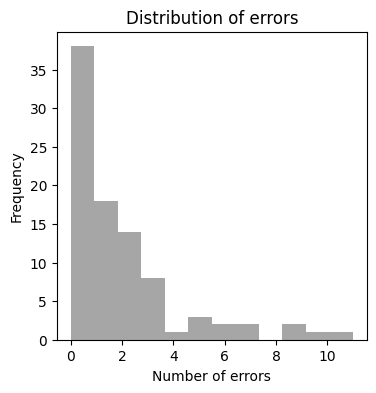

AttributeError: 'ConfusionMatrixDisplay' object has no attribute 'figure_'

In [126]:
accuracy = test(
    model = ResNet,
    test_data=conv_test,
    show_matrix=True,
    show_distribution=True
)
print(accuracy)

Entering epoch n°1
inputs shape : torch.Size([50, 1, 28, 28])
outputs shape : torch.Size([50, 10])
Epoch 1/5 - Loss: 0.0042 - 16.5s.
Entering epoch n°2
Epoch 2/5 - Loss: 0.0015 - 15.9s.
Entering epoch n°3
Epoch 3/5 - Loss: 0.0012 - 15.7s.
Entering epoch n°4
Epoch 4/5 - Loss: 0.0010 - 15.7s.
Entering epoch n°5
Epoch 5/5 - Loss: 0.0009 - 15.7s.
0.0008927247165711984
torch.Size([1, 1, 28, 28])
torch.Size([1, 10])


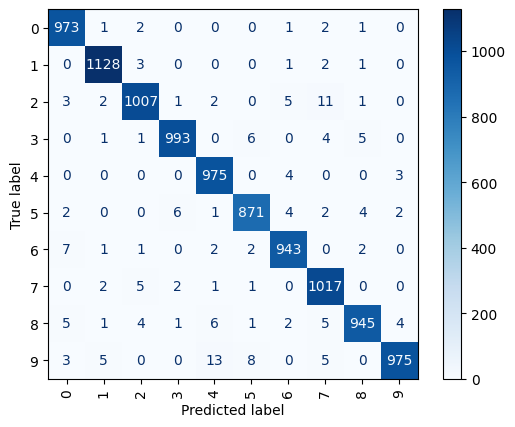

0.9827


In [115]:
# ResNet bottleneck (l = 3, h = 2)

ResNet = ResidualModel(
    l=3, # number of residual blocks
    h=2, # bottleneck h < out
    k=3, # kernel of first conv
    out=8 # number of output channels after first conv2D 
)

NUM_EPOCH = 5

opti, loss = train(
    model=ResNet,
    epoch=NUM_EPOCH,
    criterion=nn.CrossEntropyLoss(),
    training_data=conv_train,
    optimizer=torch.optim.SGD(ResNet.parameters(), lr=0.01, momentum=0.9),
    batch_size=50
    )
print(loss)

accuracy = test(
    model = ResNet,
    test_data=conv_test,
    show_matrix=True
)
print(accuracy)

Entering epoch n°1
inputs shape : torch.Size([50, 1, 28, 28])
outputs shape : torch.Size([50, 10])
Epoch 1/5 - Loss: 0.0042 - 15.9s.
Entering epoch n°2
Epoch 2/5 - Loss: 0.0015 - 15.6s.
Entering epoch n°3
Epoch 3/5 - Loss: 0.0012 - 15.6s.
Entering epoch n°4
Epoch 4/5 - Loss: 0.0010 - 15.5s.
Entering epoch n°5
Epoch 5/5 - Loss: 0.0009 - 15.5s.
0.000949519766869101
torch.Size([1, 1, 28, 28])
torch.Size([1, 10])


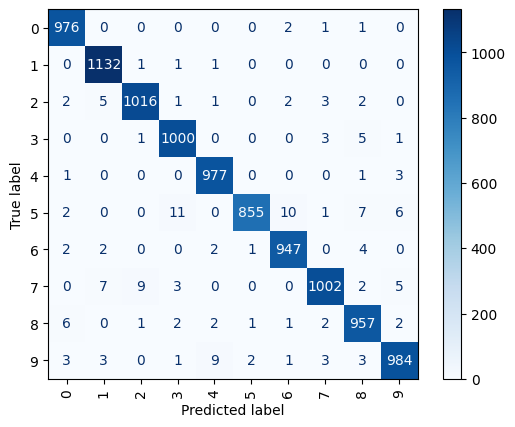

0.9846


In [116]:
# ResNet block (l = 8, h = 4)

ResNet = ResidualModel(
    l=3, # number of residual blocks
    h=2, # bottleneck h < out
    k=3, # kernel of first conv
    out=8 # number of output channels after first conv2D 
)

NUM_EPOCH = 5

opti, loss = train(
    model=ResNet,
    epoch=NUM_EPOCH,
    criterion=nn.CrossEntropyLoss(),
    training_data=conv_train,
    optimizer=torch.optim.SGD(ResNet.parameters(), lr=0.01, momentum=0.9),
    batch_size=50
    )
print(loss)

accuracy = test(
    model = ResNet,
    test_data=conv_test,
    show_matrix=True
)
print(accuracy)

# Part C - Reimplementing loss functions

## C.0 - Combining losses
First, we recall that, for a batch of score vectors \( s \in \mathbb{R}^{n \times C} \) and true labels \( y \in [1, C]^n \), **cross entropy** is defined as

\[
CE(s, y) = -\frac{1}{n} \sum_{i=1}^n \log\left( \text{softmax}(s_i)_{y_i} \right)
\]

where \( \text{softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}} \) is the probability associated to class \( i \in [1, C] \) for a score vector \( x \in \mathbb{R}^C \).

Let's try to compute cross-entropy in three different ways (see the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)):

1. Using `nn.CrossEntropyLoss()`.
2. Using `nn.NLLLoss()` and `nn.LogSoftmax()`.
3. Using `nn.NLLLoss()` and `nn.Softmax()`.

Check that the output is the same for all three methods on Gaussian random scores `torch.randn(n_batch, n_classes)` and random labels `torch.randint(0, n_classes, [n_batch])`, where `n_batch = 4` and `n_classes = 10`. Note that the scores are real-valued vectors while the labels are integers corresponding to the true class.


In [ ]:
n_batch, n_classes = 4, 10
scores = torch.randn(n_batch, n_classes)
labels = torch.randint(0, n_classes, [n_batch])

def CEL_1(scores, labels):
    """
    Using directly nn.CrossEntropyLoss()
    """
    loss = nn.CrossEntropyLoss()
    return loss(scores, labels)


def CEL_2(scores, labels):
    """
    Using nn.LogSoftmax() and nn.NLLLoss()
    """
    log_softmax = nn.LogSoftmax(dim=1)
    nll_loss = nn.NLLLoss()
    return nll_loss(log_softmax(scores), labels)


def CEL_3(scores, labels):
    """
    Using nn.NLLLoss() and nn.Softmax()
    """
    softmax = nn.Softmax(dim=1)
    nll_loss = nn.NLLLoss()
    return nll_loss(torch.log(softmax(scores)), labels)

loss1 = CEL_1(scores, labels)
loss2 = CEL_2(scores, labels)
loss3 = CEL_3(scores, labels)

print(f"Loss1: {loss1.item()}, Loss2: {loss2.item()}, Loss3: {loss3.item()}")


Loss1: 2.770742416381836, Loss2: 2.770742416381836, Loss3: 2.770742416381836


## C.1 - Re-implementation
Now re-implement cross-entropy using base functions (`torch.log`, `torch.exp`, `torch.sum`, etc...). Verify that your function returns the same value as Pytorch's implementation.

In [36]:
def ce(logits, targets):
    # Compute softmax probabilities
    probabilities = torch.exp(logits) / torch.sum(torch.exp(logits), dim=1, keepdim=True)
    
    # Gather the probabilities corresponding to the target classes
    target_probabilities = probabilities[range(len(targets)), targets]
    
    # Compute the negative log likelihood
    ce_loss = -torch.mean(torch.log(target_probabilities))
    return ce_loss

## C.2 - Stability analysis
Softmax probabilities can be relatively unstable due to their use of exponentials. Pytorch implementations thus usually use log probas or logits to avoid overflows or floating point errors. Test all methods (including your own) on Gaussian random scores of standard deviation equal to $100$. Which methods are stable? Why? Is it an issue in practice?

In [60]:
# Generate Gaussian random scores with high standard deviation
high_std_scores = torch.randn(n_batch, n_classes) * 100

# Test all methods on these scores
try:
    loss1_high_std = CEL_1(high_std_scores, labels)
    print(f"Loss1 (nn.CrossEntropyLoss): {loss1_high_std.item()}")
except Exception as e:
    print(f"Loss1 failed: {e}")

try:
    loss2_high_std = CEL_2(high_std_scores, labels)
    print(f"Loss2 (LogSoftmax + NLLLoss): {loss2_high_std.item()}")
except Exception as e:
    print(f"Loss2 failed: {e}")

try:
    loss3_high_std = CEL_3(high_std_scores, labels)
    print(f"Loss3 (Softmax + NLLLoss): {loss3_high_std.item()}")
except Exception as e:
    print(f"Loss3 failed: {e}")

try:
    loss_custom_high_std = ce(high_std_scores, labels)
    print(f"Custom CE Loss: {loss_custom_high_std.item()}")
except Exception as e:
    print(f"Custom CE Loss failed: {e}")

Loss1 (nn.CrossEntropyLoss): 148.78067016601562
Loss2 (LogSoftmax + NLLLoss): 148.78067016601562
Loss3 (Softmax + NLLLoss): inf
Custom CE Loss: inf


Re-implement a stable version of cross-entropy.

In [61]:
def stable_ce(logits, targets):
    # Shift logits by subtracting the max value for numerical stability
    shifted_logits = logits - torch.max(logits, dim=1, keepdim=True).values
    
    # Compute log-sum-exp in a numerically stable way
    log_sum_exp = torch.log(torch.sum(torch.exp(shifted_logits), dim=1, keepdim=True))
    
    # Compute log probabilities
    log_probabilities = shifted_logits - log_sum_exp
    
    # Gather the log probabilities corresponding to the target classes
    target_log_probabilities = log_probabilities[range(len(targets)), targets]
    
    # Compute the negative log likelihood
    stable_ce_loss = -torch.mean(target_log_probabilities)
    return stable_ce_loss


In [74]:
# Generate Gaussian random scores with high standard deviation
high_std_scores = torch.randn(n_batch, n_classes) * 100

# Test all methods on these scores
try:
    loss1_high_std = CEL_1(high_std_scores, labels)
    print(f"Loss1 (nn.CrossEntropyLoss): {loss1_high_std.item()}")
except Exception as e:
    print(f"Loss1 failed: {e}")

try:
    loss2_high_std = CEL_2(high_std_scores, labels)
    print(f"Loss2 (LogSoftmax + NLLLoss): {loss2_high_std.item()}")
except Exception as e:
    print(f"Loss2 failed: {e}")

try:
    loss3_high_std = CEL_3(high_std_scores, labels)
    print(f"Loss3 (Softmax + NLLLoss): {loss3_high_std.item()}")
except Exception as e:
    print(f"Loss3 failed: {e}")

try:
    loss_custom_high_std = ce(high_std_scores, labels)
    print(f"Custom CE Loss: {loss_custom_high_std.item()}")
except Exception as e:
    print(f"Custom CE Loss failed: {e}")

try:
    stable_loss_custom_high_std = stable_ce(high_std_scores, labels)
    print(f"Stable Custom CE Loss: {stable_loss_custom_high_std.item()}")
except Exception as e:
    print(f"Stable Custom CE Loss failed: {e}")

Loss1 (nn.CrossEntropyLoss): 92.05735778808594
Loss2 (LogSoftmax + NLLLoss): 92.05735778808594
Loss3 (Softmax + NLLLoss): inf
Custom CE Loss: nan
Stable Custom CE Loss: 92.05736541748047
